In [482]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_lyapunov
import matplotlib.pyplot as plt

a0 = -1
a1 = 1
b0 = 2

A = np.array([[0, 1],
              [-a0, -a1]])
b = np.array([[0.0],
              [b0]])

am0, am1 = 256.0, 32.0
Am = np.array([[0, 1],
               [-am0, -am1]])
bm = np.array([[0.0],
               [am0]])

theta = np.array([[(a0 - am0)/b0],
                  [(a1 - am1)/b0]])

kappa = b0 / am0
Q = np.eye(2)
P = solve_continuous_lyapunov(Am.T, -Q)


In [483]:
'ПРИБРАТЬСЯ В НАЗВАНИЯХ ДУБЛИРОВАННЫХ ФУНКЦИЙ!'


def get_g(t):
    return np.sign(np.sin(0.5 * t)) + 2

def control_u(x, theta_hat, g, kappa):
    """Закон управления"""
    # return float(theta_hat.T @ x + g / kappa)

    # return     float((theta_hat.T @ x + g / kappa)[0])
    return theta_hat.T @ x + g / kappa


def get_u_not_adapt(x, theta, g, kappa):
    # Убедимся, что theta имеет правильную форму для умножения
    theta = theta.reshape(-1)  # преобразуем в одномерный массив формы (2,)
    
    # Вычисляем скалярное произведение для каждой строки x
    dot_product = np.sum(x * theta, axis=1)
    
    # Убедимся, что g имеет правильную форму
    if g.ndim > 1:
        g = g.flatten()
    
    return dot_product + g / kappa

def theta_hat_dot_func(x, xm, P, b):
    """Закон адаптации"""
    gamma = 1
    # e = xm - x
    e = x - xm
    # return gamma * x @ (b.T @ P @ e)
    return -gamma * x @ (b.T @ P @ e)


In [484]:
def get_y(C, x):
    return C @ x

def get_x_dot(A, x, B, u):
    return A @ x + B @ u

def get_xm_dot(Am, xm, bm, g):
    return Am @ xm + bm @ g

In [485]:
t_span = (0, 0.5)
t = np.linspace(t_span[0], t_span[1], 1000)
g = get_g(t)

# y0 = np.zeros(6)
# x = state[0:2].reshape(2, 1)
# xm = state[2:4].reshape(2, 1)
# # theta_hat = state[4:6].reshape(2, 1)


# get_xm_dot(Am, x, bm, g)

In [486]:
def closed_loop(t, state):
    """
    state = [x(2), xm(2), theta_hat(2)]
    """
    x = state[0:2].reshape(2, 1)
    xm = state[2:4].reshape(2, 1)
    theta_hat = state[4:6].reshape(2, 1)

    g = get_g(t)
    u = control_u(x, theta_hat, g, kappa)

    x_dot = A @ x + b * u
    # ПРОВЕРИТЬ МАТРИЦУ g ДОЛЖНА ЛИ ОНА БЫТЬ СКАЛЯРОМ ИЛИ УМНОЖАТЬ НАДО НА МАТРИЦУ
    xm_dot = Am @ xm + bm * g
    theta_hat_dot = theta_hat_dot_func(x, xm, P, b)

    return np.vstack((x_dot, xm_dot, theta_hat_dot)).flatten()


In [487]:
# начальные условия: все нули
y0 = np.zeros(6)
sol = solve_ivp(closed_loop, t_span, y0,
                method='RK45', max_step=0.01, dense_output=True)
Y = sol.sol(t).T    # shape: (N,6)

x = Y[:, 0:2]
xm = Y[:, 2:4]        
theta_hat = Y[:, 4:6]

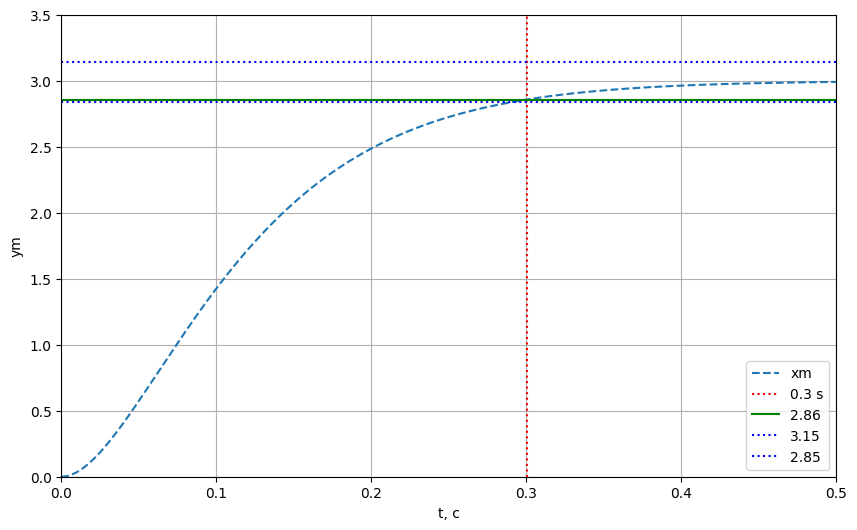

In [488]:
plt.figure(figsize=(10,6))
plt.ylim(top=3.5)
plt.xlim(right=t_span[1])
plt.plot(t, xm[:,0], '--', label='xm')

x_value = xm[600, 0]  # Значение x[300, 0]
t_value = t[600]     # Соответствующее значение времени

plt.axvline(x=t_value, color='r', linestyle=':', label=f'0.3 s')
plt.axhline(y=x_value, color='g', linestyle='-', label=f'{x_value:.2f}')

plt.axhline(y=float(xm[-1][0])*1.05, color='b', linestyle=':', label='3.15')
plt.axhline(y=float(xm[-1][0])*0.95, color='b', linestyle=':', label='2.85')


# plt.title("Состояние эталонной модели")
plt.xlabel("t, c")
plt.ylabel("ym")
plt.legend()
plt.grid()


plt.show()

In [489]:
theta

array([[-128.5],
       [ -15.5]])

In [490]:
u_not_adapt = get_u_not_adapt(x, theta, g, kappa)

Написать функцию для ВСВ и получения x по u
Построить график

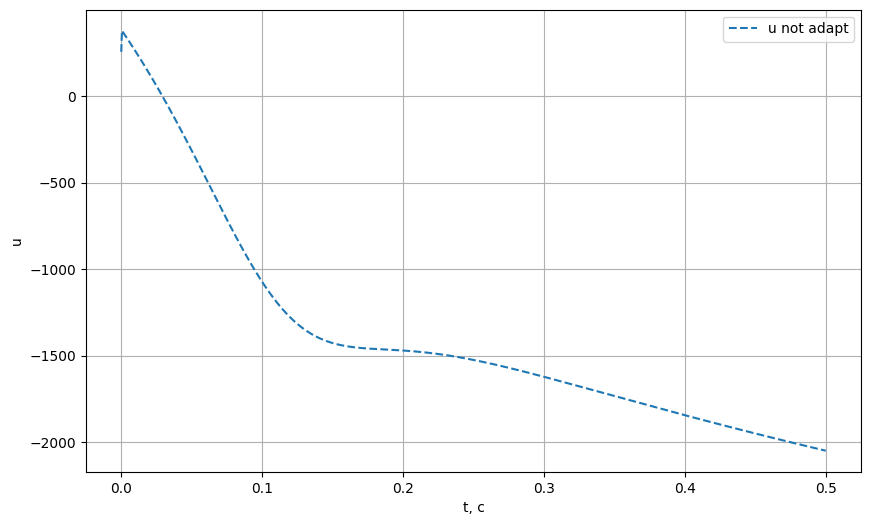

In [491]:
plt.figure(figsize=(10,6))
# plt.ylim(top=3.5)
# plt.xlim(right=t_span[1])
plt.plot(t, u_not_adapt, '--', label='u not adapt')

# plt.title("Состояние эталонной модели")
plt.xlabel("t, c")
plt.ylabel("u")
plt.legend()
plt.grid()


plt.show()

# 2 Моделирование системы с неадаптивным регулятором

In [492]:
theta = np.array([-128.5, -15.5]) # Расчетные параметры theta
# theta = np.array([-192.5, -23.5]) # Незначительно отклонить параметры
# theta = np.array([-2.0, 1.0]) # Значительно отклонить параметры

In [493]:
def closed_loop_not_adapt(t, state):
    """
    state = [x(2), xm(2)]
    """
    x = state[0:2].reshape(2, 1)
    xm = state[2:4].reshape(2, 1)

    g = get_g(t)  # скаляр
    u = float(theta @ x.flatten() + g / kappa)

    x_dot = A @ x + b * u
    # x_dot = get_x_dot(A, x, b, u)
    xm_dot = Am @ xm + bm * g
    # xm_dot = get_xm_dot(Am, xm, bm, g)

    return np.vstack((x_dot, xm_dot)).flatten()

In [494]:
t_span = (0, 200)
t = np.linspace(t_span[0], t_span[1], 1000)

y0 = np.zeros(4)               # x и xm
sol = solve_ivp(closed_loop_not_adapt, t_span, y0,
                method='RK45', max_step=0.01, dense_output=True)

t_grid = np.linspace(t_span[0], t_span[1], 1000)
Y = sol.sol(t_grid).T

x = Y[:, 0:2]
xm = Y[:, 2:4]

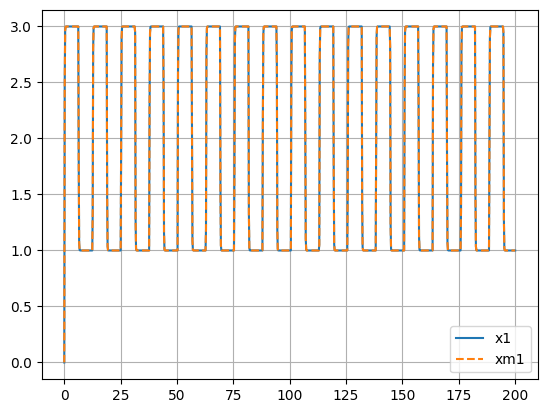

In [495]:
plt.plot(t_grid, x[:,0], label='x1')
plt.plot(t_grid, xm[:,0], '--', label='xm1')
plt.grid(); plt.legend(); plt.show()

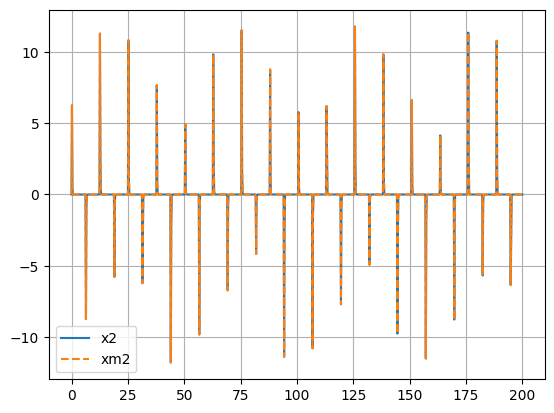

In [496]:
plt.plot(t_grid, x[:,1], label='x2')
plt.plot(t_grid, xm[:,1], '--', label='xm2')
plt.grid(); plt.legend(); plt.show()

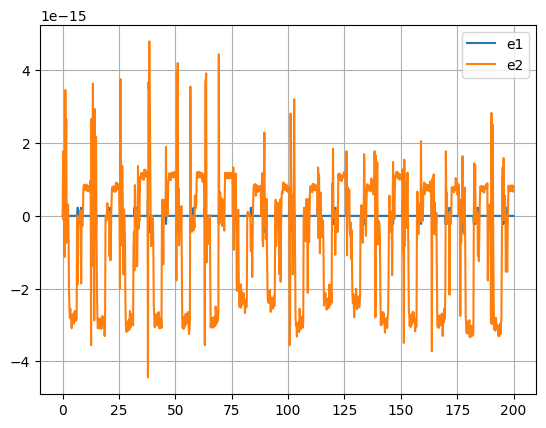

In [497]:
e = x - xm
plt.plot(t_grid, e[:,0], label='e1')
plt.plot(t_grid, e[:,1], label='e2')
plt.grid(); plt.legend(); plt.show()

# 3. Моделирование адаптивной системы